##### 1. Import Library

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

##### 2. Load Data

In [3]:
DATA_PATH = os.path.join("..", "..", "data", "processed_data_cleaned.csv")
df = pd.read_csv(DATA_PATH)
df.columns

Index(['machine_id', 'status', 'temperature', 'vibration', 'vibration_rms',
       'timestamp'],
      dtype='object')

##### 3. เลือกคอลัมน์

In [4]:
df = df[['machine_id', 'status', 'temperature', 'vibration', 'vibration_rms', 'timestamp']]

##### 4. เลือก Features และ Target

In [5]:
X_cls = df[['temperature', 'vibration', 'vibration_rms']].copy()

df['health_status'] = ((df['temperature'] > 30) | (df['vibration_rms'] > 0.5)).astype(int)
y_cls = df['health_status']
print("Health status distribution:\n", y_cls.value_counts())

Health status distribution:
 health_status
1    12896
0     1806
Name: count, dtype: int64


##### 5. ตรวจสอบ Missing Values

In [6]:
X_cls = X_cls.fillna(X_cls.mean())
print("Missing values check:\n", X_cls.isnull().sum())

Missing values check:
 temperature      0
vibration        0
vibration_rms    0
dtype: int64


##### 6. แบ่งข้อมูล Train / Test

In [7]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=42, stratify=y_cls
)

##### 7. Scaling ข้อมูล

In [8]:
scaler_cls = StandardScaler()
X_train_scaled_cls = scaler_cls.fit_transform(X_train_cls)
X_test_scaled_cls = scaler_cls.transform(X_test_cls)

##### 8. Train Random Forest Model

In [9]:
rf_cls = RandomForestClassifier(random_state=42)
rf_cls.fit(X_train_scaled_cls, y_train_cls)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### 9. ประเมินผล Model

In [10]:
y_pred_train_cls = rf_cls.predict(X_train_scaled_cls)
y_pred_test_cls = rf_cls.predict(X_test_scaled_cls)

print("Training Accuracy:", accuracy_score(y_train_cls, y_pred_train_cls))
print("Testing Accuracy :", accuracy_score(y_test_cls, y_pred_test_cls))
print("\nClassification Report (Test Data):\n", classification_report(y_test_cls, y_pred_test_cls))

Training Accuracy: 1.0
Testing Accuracy : 1.0

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       542
           1       1.00      1.00      1.00      3869

    accuracy                           1.00      4411
   macro avg       1.00      1.00      1.00      4411
weighted avg       1.00      1.00      1.00      4411



##### 10. Feature Importance

C:\Users\Sittinon\AppData\Local\Temp\ipykernel_29428\119903676.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_cls.feature_importances_, y=X_cls.columns, palette='viridis')


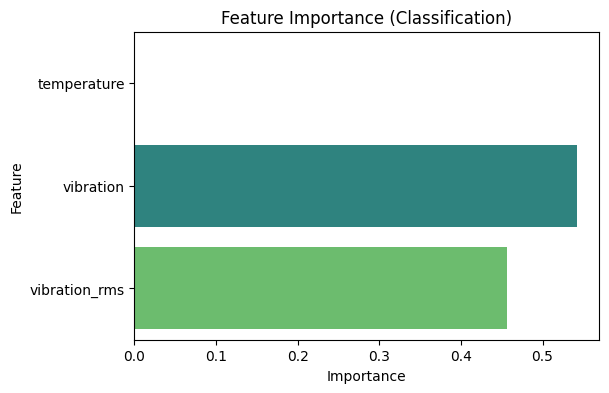

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(x=rf_cls.feature_importances_, y=X_cls.columns, palette='viridis')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Classification)")
plt.show()

##### 11. Cross-validation

In [12]:
cv_scores = cross_val_score(rf_cls, X_train_scaled_cls, y_train_cls, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000


##### 12. Regression: Predict Vibration

In [13]:
X_reg = df[['temperature']].copy()
y_reg = df['vibration'].copy()

##### 13. Train/Test split

In [14]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train_reg)}, Testing samples: {len(X_test_reg)}")

Training samples: 11761, Testing samples: 2941


##### 14. Train RandomForestRegressor

In [15]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### 15. Predict and evaluate

In [16]:
y_pred_reg = rf_reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.08586828211238218


##### 16. Visualization: Actual vs Predicted

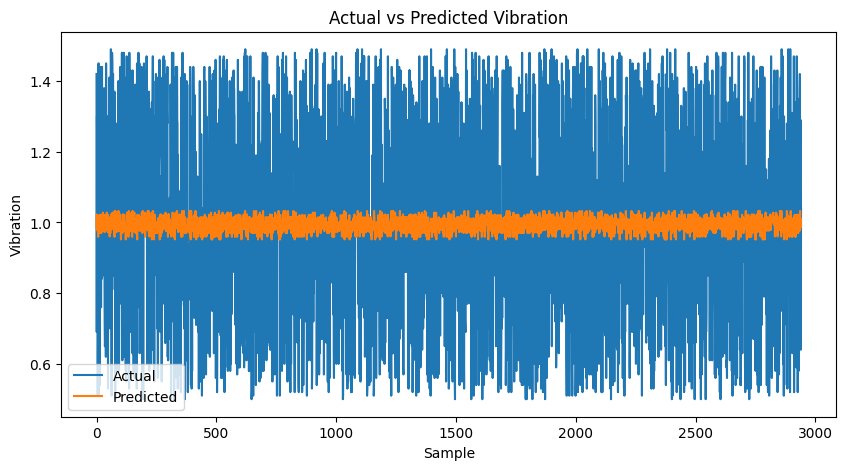

In [17]:
plt.figure(figsize=(10,5))
plt.plot(y_test_reg.values, label='Actual')
plt.plot(y_pred_reg, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Vibration')
plt.legend()
plt.title("Actual vs Predicted Vibration")
plt.show()

##### 17. Optional: Real-time Simulation from Wokwi 

In [18]:
wokwi_path = '../data/wokwi_output.txt'
if os.path.exists(wokwi_path):
    # อ่านไฟล์ใหม่
    try:
        wokwi_data = pd.read_csv(wokwi_path)
    except:
        # ถ้าเป็นไฟล์ JSON lines
        wokwi_data = pd.read_json(wokwi_path, lines=True)
    
    # สำหรับ classifier
    X_new_cls = wokwi_data[['temperature', 'vibration', 'vibration_rms']].fillna(0)
    X_new_cls_scaled = scaler_cls.transform(X_new_cls)
    pred_health = rf_cls.predict(X_new_cls_scaled)
    print("Predicted Health Status (new data):", pred_health)
    
    # สำหรับ regressor
    X_new_reg = wokwi_data[['temperature']].fillna(0)
    pred_vibration = rf_reg.predict(X_new_reg)
    print("Predicted Vibration (new data):", pred_vibration)

##### 18. บันทึก Model และ Scaler

In [19]:
joblib.dump(rf_cls, "random_forest_arduino_classifier.pkl")
joblib.dump(scaler_cls, "arduino_scaler.pkl")
joblib.dump(rf_reg, "random_forest_vibration_model.pkl")

['random_forest_vibration_model.pkl']